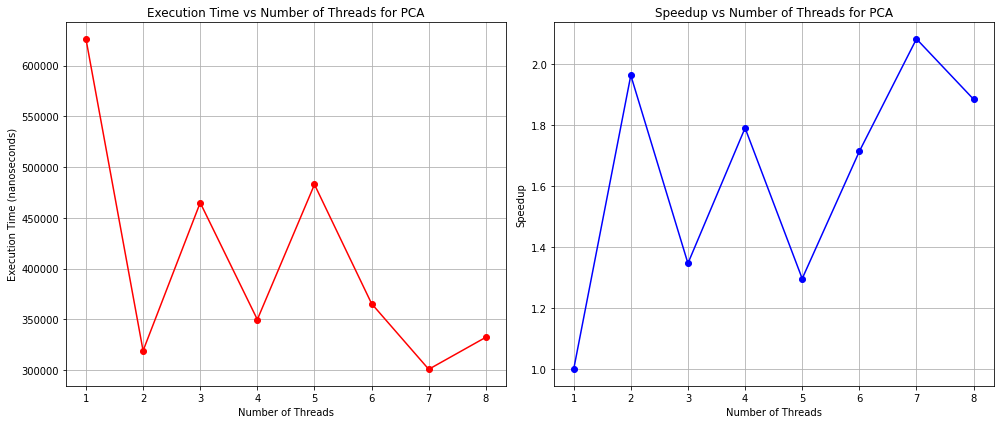

Execution times (nanoseconds):
1 thread(s): 626360.00 ns
2 thread(s): 319010.00 ns
3 thread(s): 464912.00 ns
4 thread(s): 349760.00 ns
5 thread(s): 482870.00 ns
6 thread(s): 365391.00 ns
7 thread(s): 300724.00 ns
8 thread(s): 332291.00 ns


In [41]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import time
import matplotlib.pyplot as plt

# Load and standardize the Wine dataset
wine = load_wine()
X = wine['data']
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Function to compute covariance matrix
def compute_covariance(X):
    return np.dot(X.T, X) / (X.shape[0] - 1)

# Function to perform eigen decomposition
def eigen_decomposition(cov_matrix):
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eig_vals)[::-1]
    return eig_vals[sorted_indices], eig_vecs[:, sorted_indices]

# Function to time PCA process with averaging over multiple runs
def time_pca(num_threads, num_runs=100):
    total_time = 0
    for _ in range(num_runs):
        start_time = time.time_ns()

        # Compute covariance matrix
        cov_matrix = compute_covariance(X_std)

        # Perform eigen decomposition using specified number of threads
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            eig_vals, eig_vecs = executor.submit(eigen_decomposition, cov_matrix).result()

        end_time = time.time_ns()
        total_time += (end_time - start_time)

    return total_time / num_runs  # Return average execution time

# Test with varying number of threads and average over multiple runs
thread_execution_times = [(num_threads, time_pca(num_threads)) for num_threads in range(1, 9)]

# Calculate speedup based on average execution times
single_thread_time = thread_execution_times[0][1]
speedup = [(num_threads, single_thread_time / exec_time if exec_time > 0 else 0) for num_threads, exec_time in thread_execution_times]

# Unpack results for plotting
threads, times = zip(*thread_execution_times)
_, speedups = zip(*speedup)

# Create a subplot to display both execution time and speedup
plt.figure(figsize=(14, 6))

# Plot execution time vs number of threads
plt.subplot(1, 2, 1)
plt.plot(threads, times, marker='o', linestyle='-', color='r')
plt.title('Execution Time vs Number of Threads for PCA')
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (nanoseconds)')
plt.xticks(threads)
plt.grid(True)

# Plot speedup vs number of threads
plt.subplot(1, 2, 2)
plt.plot(threads, speedups, marker='o', linestyle='-', color='b')
plt.title('Speedup vs Number of Threads for PCA')
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.xticks(threads)
plt.grid(True)

plt.tight_layout()
plt.show()

# Print execution times
print("Execution times (nanoseconds):")
for thread, time in thread_execution_times:
    print(f"{thread} thread(s): {time:.2f} ns")